In [1]:
# dont forget to switch to GPU if possible
google_colab_env = False

In [2]:
if google_colab_env:
    from google.colab import drive
    %tensorflow_version 1.x
    drive.mount('/content/drive')
    !git clone https://github.com/GrzegorzKazana/artificial-music.git

## importing dataset, splitting tracks

In [5]:
import os
import sys
import json
import numpy as np
from scipy import sparse

proj_base_path = ('/content/artificial-music' 
                  if google_colab_env else '../../../')

data_base_path =  ('/content/drive/My Drive/artificial-music/datasets'
                   if google_colab_env else '../../../datasets')

models_base_path =  ('/content/drive/My Drive/artificial-music/pretrained_models' 
                     if google_colab_env else '../../../pretrained_models')

sys.path.append(os.path.join(os.getcwd(), proj_base_path))

dataset_path = 'numpy/pokemon_clustered_time_no_transp'
word_vectors_file = 'meta/_word_vectors_5000_ignore_ratio=0.05.wv'
duration_dict_file = 'meta/durations_dict.json'

In [6]:
word_vectors_path = os.path.join(data_base_path, dataset_path, word_vectors_file)
with open(os.path.join(data_base_path, dataset_path, duration_dict_file)) as fp:
    duration_dict = json.load(fp)

tracks_path = os.path.join(data_base_path, dataset_path)
track_paths = [os.path.join(tracks_path, f) for f in os.listdir(tracks_path) if f.endswith('.npz')]

tracks = [sparse.load_npz(p).tocsr().toarray() for p in track_paths]

for t in tracks: print(t.shape, end='')

(917, 152)(487, 152)(551, 152)(228, 152)(343, 152)(1002, 152)(317, 152)(253, 152)(121, 152)(389, 152)

In [ ]:
# dropping ~0 duration class datapoints
tracks = [t[t[:, 128] != 1] for t in tracks]
tracks = [t for t in tracks if t.shape[0]]

## loading embedding + encoding dataset

In [7]:
from gensim.models import KeyedVectors

wv = KeyedVectors.load(word_vectors_path, mmap='r')

In [8]:
from src.data_processing.sparse_notes_classified_time.embed_adapt import decode_note_vector_track, encode_frames, append_track_end  

note_vecs, durations = zip(*[(t[:, :128], t[:, 128:]) for t in tracks])

note_vecs = [encode_frames(sparse.csr_matrix(t), wv) for t in note_vecs]

tracks_embedded = [np.concatenate((n_v, d), axis=1) for n_v, d in zip(note_vecs, durations)]

len(tracks_embedded), tracks_embedded[0].shape

(10, (917, 40))

### prepare dataset generator

In [9]:
def dataset_gen(tracks, window_size_range=(20, 300), batch_size=16):
    """
    tracks - list of np.arrays of shape (track_length, frame_size)
    window_size - length of generated batch
    batch_size - number of sequences in batch
    """
    max_window_size = min([len(t) for t in tracks]) - 3
    while True:
        window_size = np.random.randint(window_size_range[0], min(max_window_size, window_size_range[1]))
        # select #batch_size tracks
        selected_track_indicies = [np.random.randint(0, len(tracks)) for _ in range(batch_size)]
        # select sequence starting point for each track
        sequence_indicies = [np.random.randint(0, len(tracks[sti]) - window_size - 2)
                             for sti in selected_track_indicies]
        
        
        # create slices for x and y
        x_slice = lambda seqi: np.s_[seqi:seqi + window_size]
        y_slice = lambda seqi: np.s_[seqi + 1:seqi + window_size + 1]
        
        x = [tracks[sti][x_slice(seqi)] for sti, seqi in zip(selected_track_indicies, sequence_indicies)]
        y = [tracks[sti][y_slice(seqi)] for sti, seqi in zip(selected_track_indicies, sequence_indicies)]

        yield np.stack(x), np.stack(y)
        
x, y = next(dataset_gen(tracks_embedded, (10, 50), 5))
x.shape, y.shape

((5, 30, 40), (5, 30, 40))

## Setting up model

In [10]:
from tensorflow import keras as K

NOTES_INPUT_SIZE = 16
DURATION_INPUT_SIZE = 24

DURATION_INPUT_DENSE_SIZE = 16
DURATION_INPUT_LSTM_SIZE = 32
DURATION_OUTPUT_DENSE = 16
DURATION_OUTPUT_SIZE = DURATION_INPUT_SIZE

MAIN_LSTM_SIZE = 64
NOTES_OUTPUT_DENSE = 32
NOTES_OUTPUT_SIZE = NOTES_INPUT_SIZE

# MAIN_LSTM_SIZE = 256
# MAIN_DENSE_SIZE = 128

# NOTES_LSTM_SIZE = 64
# DURATION_LSTM_SIZE = 32

# NOTES_OUTPUT_DENSE = 32
# DURATION_OUTPUT_DENSE = 32

# NOTES_OUTPUT_SIZE = NOTES_INPUT_SIZE
# DURATION_OUTPUT_SIZE = DURATION_INPUT_SIZE

BATCH_SIZE = 16
WINDOW_SIZE_RANGE = (10, 25)

NOTES_INPUT_SHAPE = (None, NOTES_INPUT_SIZE)
DURATION_INPUT_SHAPE = (None, DURATION_INPUT_SIZE)
# None allows for variable seq_length between batches

NOTES_INPUT_NAME = 'notes_input'
DURATION_INPUT_NAME = 'duration_input'
NOTES_OUTPUT_NAME = 'notes_output'
DURATION_OUTPUT_NAME = 'duration_output'

#### load existing model

In [ ]:
# or load saved model
model_path = 'lstm_lstm/embedded_16_128_stacked_32/embedded_16_128_stacked_32md_e200_t2019-10-09T09_59_31_cpu.h5'
model = K.models.load_model(os.path.join(models_base_path, model_path))

#### or create new one

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, CuDNNLSTM, Input, Concatenate
rnn_layer = CuDNNLSTM if google_colab_env else LSTM

# x1 = Input(NOTES_INPUT_SHAPE, name=NOTES_INPUT_NAME)
# x2 = Input(DURATION_INPUT_SHAPE, name=DURATION_INPUT_NAME)
# x3 = Dense(DURATION_INPUT_DENSE_SIZE)(x2)

# h1 = Concatenate()([x1, x3])
# h2 = rnn_layer(MAIN_LSTM_SIZE, return_sequences=True)(h1)
# h3 = Dense(MAIN_DENSE_SIZE)(h2)

# g1 = rnn_layer(NOTES_LSTM_SIZE, return_sequences=True)(h3)
# g2 = Dense(NOTES_OUTPUT_DENSE)(g1)
# y1 = Dense(NOTES_OUTPUT_SIZE, name=NOTES_OUTPUT_NAME)(g2)

# i1 = rnn_layer(DURATION_LSTM_SIZE, return_sequences=True)(h3)
# i2 = Dense(DURATION_OUTPUT_DENSE)(i1)
# y2 = Dense(DURATION_OUTPUT_SIZE, name=DURATION_OUTPUT_NAME, activation='softmax')(i2)

# model = Model(inputs=[x1, x2], outputs=[y1, y2])

x1 = Input(NOTES_INPUT_SHAPE, name=NOTES_INPUT_NAME)
z1 = Input(DURATION_INPUT_SHAPE, name=DURATION_INPUT_NAME)

z2 = Dense(DURATION_INPUT_DENSE_SIZE)(z1)
z3 = rnn_layer(DURATION_INPUT_LSTM_SIZE, return_sequences=True)(z2)
z4 = Dense(DURATION_OUTPUT_DENSE)(z3)
z5 = Dense(DURATION_OUTPUT_SIZE, name=DURATION_OUTPUT_NAME, activation='softmax')(z4)

h1 = Concatenate()([x1, z5])
h2 = rnn_layer(MAIN_LSTM_SIZE, return_sequences=True)(h1)
h3 = Dense(NOTES_OUTPUT_DENSE)(h2)
h4 = Dense(NOTES_OUTPUT_SIZE, name=NOTES_OUTPUT_NAME)(h3)

model = Model(inputs=[x1, z1], outputs=[z5, h4])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
duration_input (InputLayer)     [(None, None, 24)]   0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, None, 16)     400         duration_input[0][0]             
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 32)     6272        dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, None, 16)     528         lstm[0][0]                       
_____________

In [12]:
losses = {
    NOTES_OUTPUT_NAME: 'mse',
    DURATION_OUTPUT_NAME: 'categorical_crossentropy',
}

metrics = {
    NOTES_OUTPUT_NAME: ['mse'],
    DURATION_OUTPUT_NAME: ['categorical_accuracy'],
}

# maybe diffrent weights for outputs???

model.compile(
    loss=losses,
    optimizer='adam', 
    metrics=metrics,
)

#### define training callbacks

In [13]:
from src.training.common.training_callbacks import ModelAndLogSavingCallback, GeneratingAndPlottingCallback

# logging callback
# logging_path = 'lstm_clustered_time'
# experiment_name = f'embedded_clustered_time_{MAIN_LSTM_SIZE}_no_shortest'
# experiment_path = os.path.join(models_base_path, logging_path, experiment_name)
# os.makedirs(experiment_path, exist_ok=True)
# print(f'saving checkpoints and logs to {experiment_path}')

# # logging disabled for now
# log_callback = ModelAndLogSavingCallback(model, experiment_path, save_log_only=True)

# generating callback
from src.generating.generating import recurrent_generate
from src.generating.embedded_clustered_time_generating_seeds import get_seed_generators
from src.data_processing.common.helpers import pipe
from src.data_processing.sparse_notes_classified_time.np2mid import np2sparse
from src.data_processing.sparse_notes_classified_time.embed_adapt import decode_note_vector_track

SEED_LENGTH = 5
GENERATED_SEQ_LENGTH = 50
GENERATING_WINDOW_SIZE = 15

sd = get_seed_generators(duration_dict, ignore_shortest=True)

def seed_generator():
    return np.concatenate([
        sd['random_noise_seed'](SEED_LENGTH, NOTES_INPUT_SIZE, batch_size=BATCH_SIZE // 4),
        sd['zero_seed'](SEED_LENGTH, NOTES_INPUT_SIZE, word_vectors=wv, batch_size=BATCH_SIZE // 4),
        sd['multi_note_harmonic_seed'](SEED_LENGTH, NOTES_INPUT_SIZE, word_vectors=wv, batch_size=BATCH_SIZE // 4),
        sd['multi_note_harmonic_seed_noise'](SEED_LENGTH, NOTES_INPUT_SIZE, word_vectors=wv, batch_size=BATCH_SIZE // 4),
    ], axis=0)

sample_generator = lambda model, seed: recurrent_generate(
    model, 
    seed, 
    GENERATED_SEQ_LENGTH, 
    GENERATING_WINDOW_SIZE, 
    is_binary=False,
    transform_input=lambda x: (x[:, :, :NOTES_INPUT_SIZE], x[:, :, NOTES_INPUT_SIZE:]),
    transform_output=lambda args: np.concatenate((args[0], args[1]), axis=2),
)

def tap(f):
    def inner(x):
        f(x)
        return x
    return inner

def print_list(l):
    for i, li in enumerate(l):
        print(i, li)

marker_end = np.zeros((BATCH_SIZE, 1, 40))
marker_end[:, :, 16] = 1

sparse_sample_generator = lambda model, seed: pipe(
    sample_generator(model, seed),
    # tap(lambda x: print(x.shape)),
    # tap(lambda x: print_list(x.tolist()[0])),
    # tap(lambda x: [print_list(np.split(np.argwhere(s)[:, 1], np.cumsum(np.unique(np.argwhere(s)[:, 0], return_counts=True)[1])[:-1])) for s in x]),
    lambda x: np.concatenate((x, marker_end), axis=1),
    lambda batch_of_samples: [
        np2sparse(
            decode_note_vector_track(s[:, :NOTES_INPUT_SIZE], wv, return_similarities=False),
            s[:, NOTES_INPUT_SIZE:],
            duration_dict,
            ppq=20,
        ) for s in batch_of_samples],
)

gen_callback = GeneratingAndPlottingCallback(model, sparse_sample_generator, seed_generator)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

mc_best = ModelCheckpoint(
    os.path.join(experiment_path, 'model_best.h5'),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)

mc_last = ModelCheckpoint(
    os.path.join(experiment_path, 'model_last.h5'),
    monitor='val_loss',
    mode='min',
    save_best_only=False,
)

es = EarlyStopping(
    monitor='val_loss',
    min_delta=1e-2,
    patience=10
)

#### training

In [14]:
# pre training code
from time import time
epochs_elapsed = 0
minutes_elapsed = 0

def dataset_gen_split_inout(X, window_size_range, batch_size):
    gen = dataset_gen(X, window_size_range, batch_size)
    while True:
        x, y = next(gen)
        x_split = {
            NOTES_INPUT_NAME: x[:, :, :NOTES_INPUT_SIZE],
            DURATION_INPUT_NAME: x[:, :, NOTES_INPUT_SIZE:],
        }
        y_split = {
            NOTES_OUTPUT_NAME: y[:, :, :NOTES_INPUT_SIZE],
            DURATION_OUTPUT_NAME: y[:, :, NOTES_INPUT_SIZE:],
        }
        yield x_split, y_split

# reserving last 25 notes for validation
tracks_embedded_train = [t[:-25] for t in tracks_embedded]
tracks_embedded_val = [t[-25:] for t in tracks_embedded]

data_gen = dataset_gen_split_inout(tracks_embedded_train, WINDOW_SIZE_RANGE, BATCH_SIZE)
test_gen = dataset_gen_split_inout(tracks_embedded_val, WINDOW_SIZE_RANGE, BATCH_SIZE)

Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
  96/1000 [=>............................] - ETA: 6s - loss: 38.6238 - duration_output_loss: 1.2330 - notes_output_loss: 37.3908 - duration_output_categorical_accuracy: 0.5668 - notes_output_mean_squared_error: 37.6942Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)


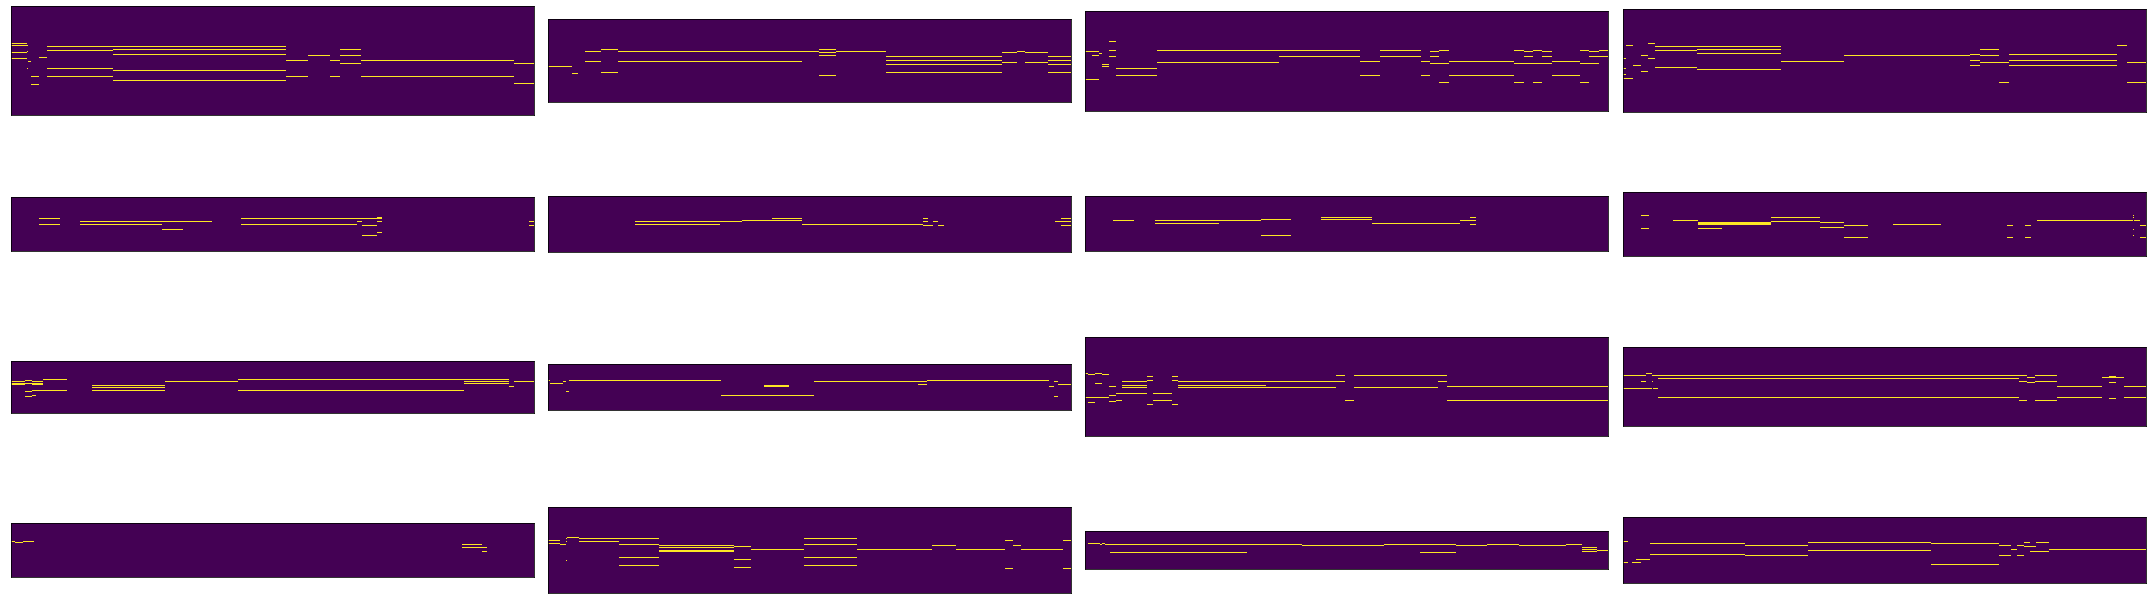

1000/1000 [==============================] - 25s 25ms/step - loss: 29.1114 - duration_output_loss: 1.4304 - notes_output_loss: 27.6810 - duration_output_categorical_accuracy: 0.5575 - notes_output_mean_squared_error: 27.5859 - val_loss: 38.7616 - val_duration_output_loss: 1.2332 - val_notes_output_loss: 37.5284 - val_duration_output_categorical_accuracy: 0.5668 - val_notes_output_mean_squared_error: 37.8404
Epoch 2/100
 100/1000 [==>...........................] - ETA: 4s - loss: 41.6083 - duration_output_loss: 1.1263 - notes_output_loss: 40.4820 - duration_output_categorical_accuracy: 0.5763 - notes_output_mean_squared_error: 40.5094Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 1 unknowns per 41 (2%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encounter

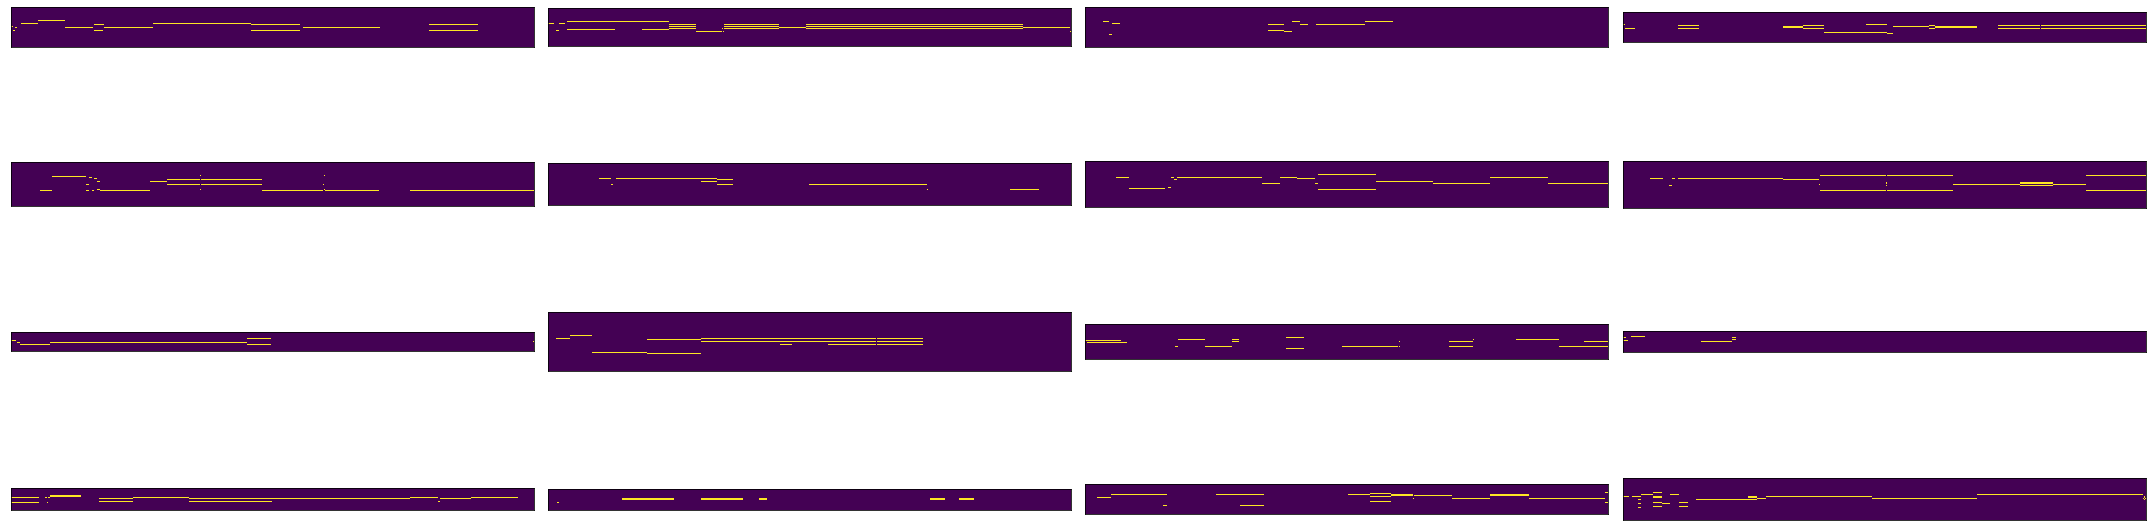

1000/1000 [==============================] - 21s 21ms/step - loss: 20.2798 - duration_output_loss: 1.0839 - notes_output_loss: 19.1959 - duration_output_categorical_accuracy: 0.6406 - notes_output_mean_squared_error: 19.0178 - val_loss: 41.6083 - val_duration_output_loss: 1.1263 - val_notes_output_loss: 40.4820 - val_duration_output_categorical_accuracy: 0.5763 - val_notes_output_mean_squared_error: 40.5094
Epoch 3/100
  97/1000 [=>............................] - ETA: 4s - loss: 42.9039 - duration_output_loss: 1.0494 - notes_output_loss: 41.8545 - duration_output_categorical_accuracy: 0.6620 - notes_output_mean_squared_error: 42.0797Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encounter

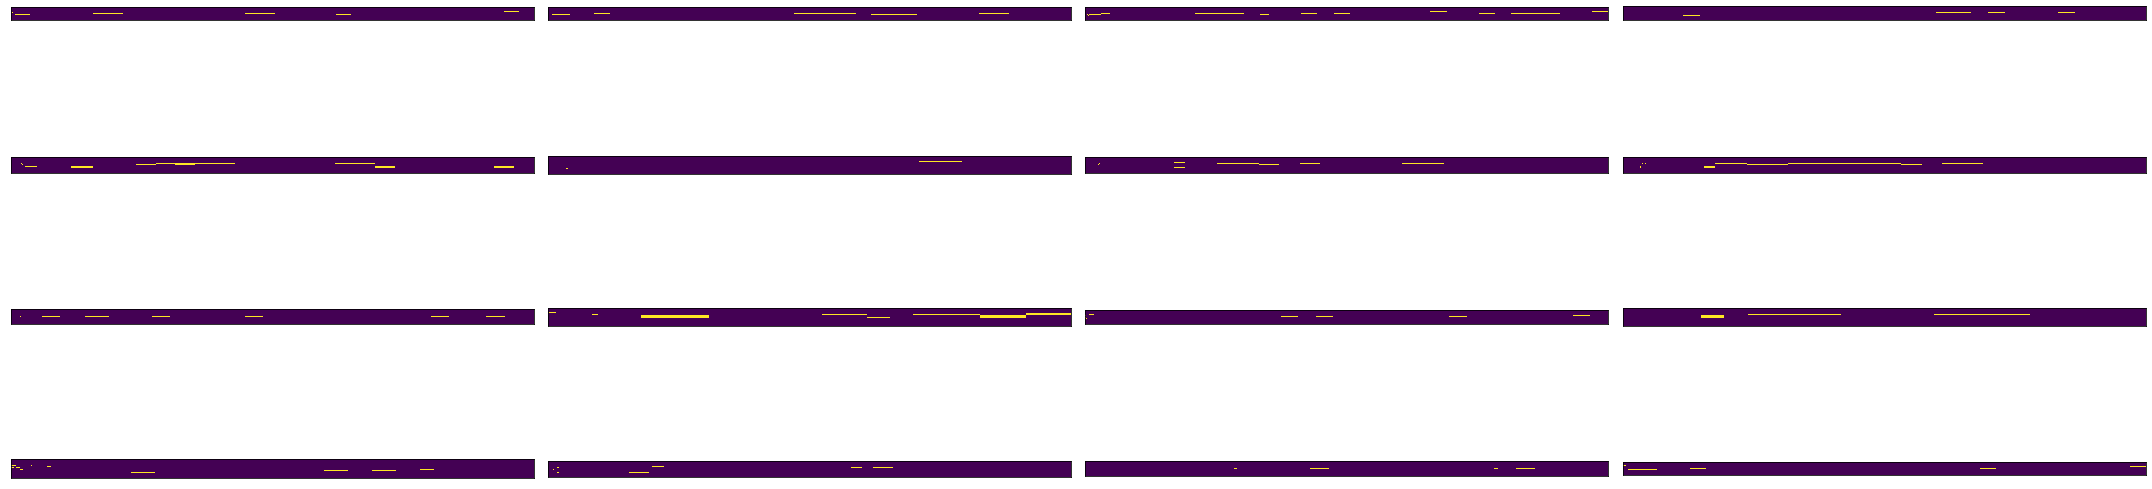

1000/1000 [==============================] - 22s 22ms/step - loss: 17.3131 - duration_output_loss: 0.9838 - notes_output_loss: 16.3293 - duration_output_categorical_accuracy: 0.6728 - notes_output_mean_squared_error: 16.1608 - val_loss: 42.6983 - val_duration_output_loss: 1.0491 - val_notes_output_loss: 41.6492 - val_duration_output_categorical_accuracy: 0.6619 - val_notes_output_mean_squared_error: 41.9068
Epoch 4/100
  88/1000 [=>............................] - ETA: 4s - loss: 42.1561 - duration_output_loss: 1.0493 - notes_output_loss: 41.1068 - duration_output_categorical_accuracy: 0.6459 - notes_output_mean_squared_error: 41.4842Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encounter

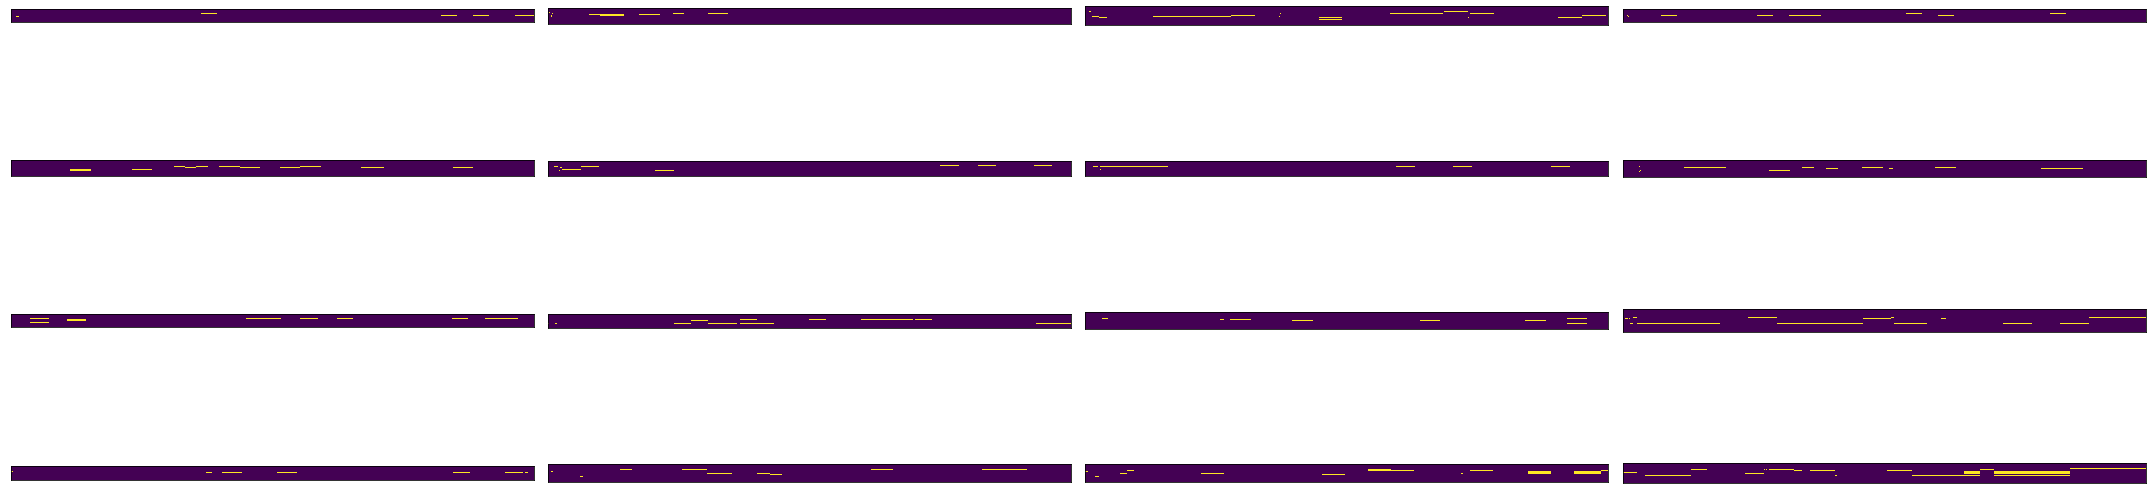

1000/1000 [==============================] - 22s 22ms/step - loss: 15.7620 - duration_output_loss: 0.9060 - notes_output_loss: 14.8560 - duration_output_categorical_accuracy: 0.6933 - notes_output_mean_squared_error: 14.6328 - val_loss: 42.1449 - val_duration_output_loss: 1.0472 - val_notes_output_loss: 41.0977 - val_duration_output_categorical_accuracy: 0.6462 - val_notes_output_mean_squared_error: 41.4608
Epoch 5/100
  94/1000 [=>............................] - ETA: 4s - loss: 43.4840 - duration_output_loss: 1.1167 - notes_output_loss: 42.3672 - duration_output_categorical_accuracy: 0.6145 - notes_output_mean_squared_error: 42.2300Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encounter

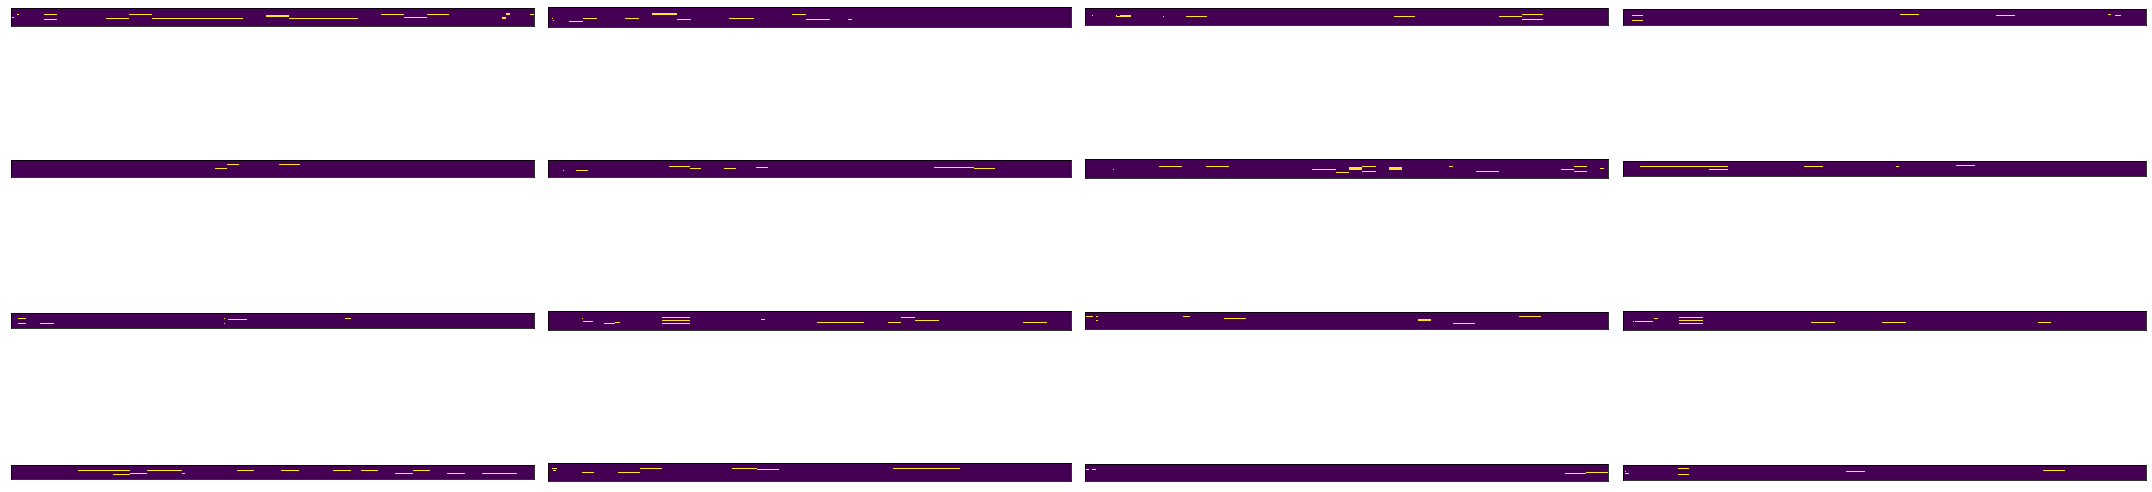

1000/1000 [==============================] - 21s 21ms/step - loss: 14.7839 - duration_output_loss: 0.8658 - notes_output_loss: 13.9181 - duration_output_categorical_accuracy: 0.7004 - notes_output_mean_squared_error: 13.6963 - val_loss: 43.6323 - val_duration_output_loss: 1.1175 - val_notes_output_loss: 42.5149 - val_duration_output_categorical_accuracy: 0.6154 - val_notes_output_mean_squared_error: 42.3844
Epoch 6/100
  97/1000 [=>............................] - ETA: 3s - loss: 45.0620 - duration_output_loss: 1.1520 - notes_output_loss: 43.9101 - duration_output_categorical_accuracy: 0.6039 - notes_output_mean_squared_error: 43.5335Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encounter

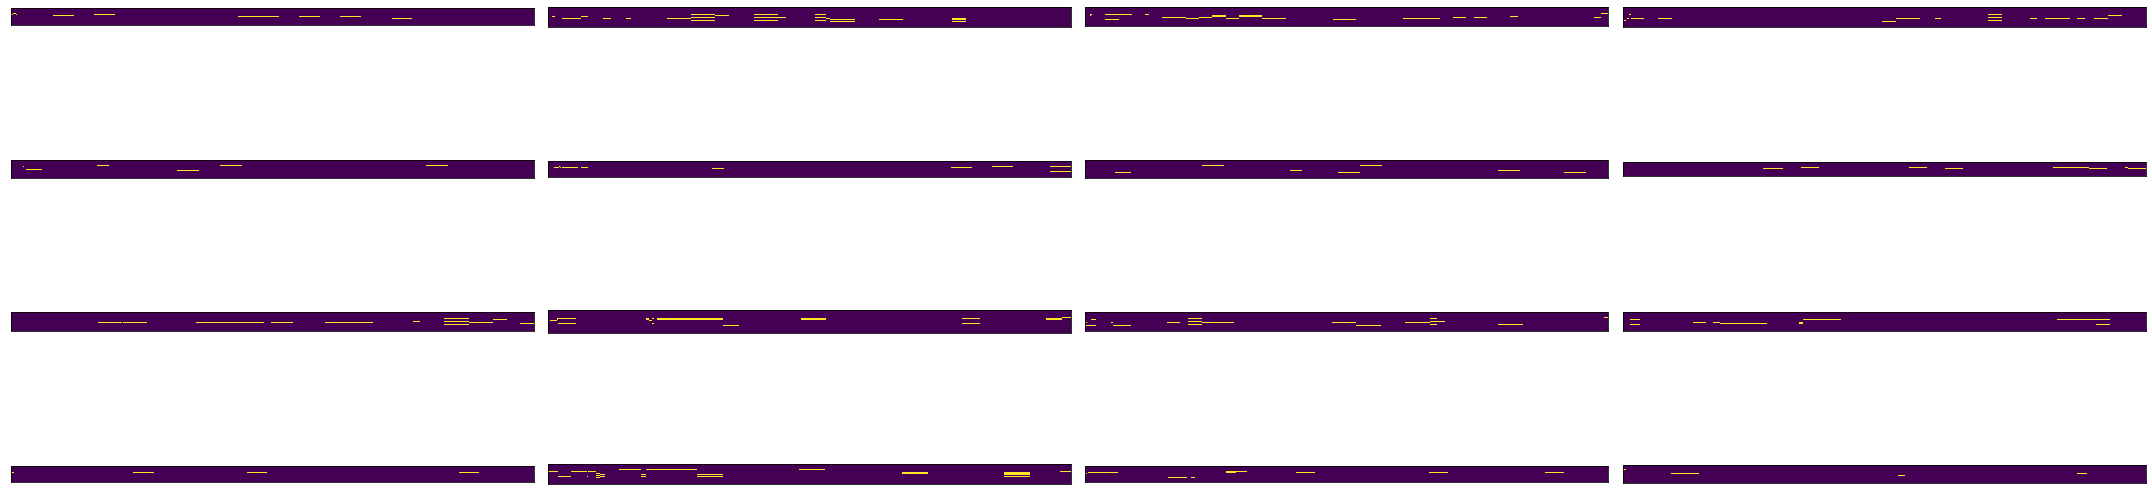

1000/1000 [==============================] - 21s 21ms/step - loss: 13.9898 - duration_output_loss: 0.8312 - notes_output_loss: 13.1586 - duration_output_categorical_accuracy: 0.7088 - notes_output_mean_squared_error: 12.9304 - val_loss: 45.1652 - val_duration_output_loss: 1.1499 - val_notes_output_loss: 44.0154 - val_duration_output_categorical_accuracy: 0.6054 - val_notes_output_mean_squared_error: 43.6111
Epoch 7/100
  92/1000 [=>............................] - ETA: 4s - loss: 45.2494 - duration_output_loss: 1.1952 - notes_output_loss: 44.0542 - duration_output_categorical_accuracy: 0.6224 - notes_output_mean_squared_error: 43.9964Encountered 1 unknowns per 41 (2%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encounter

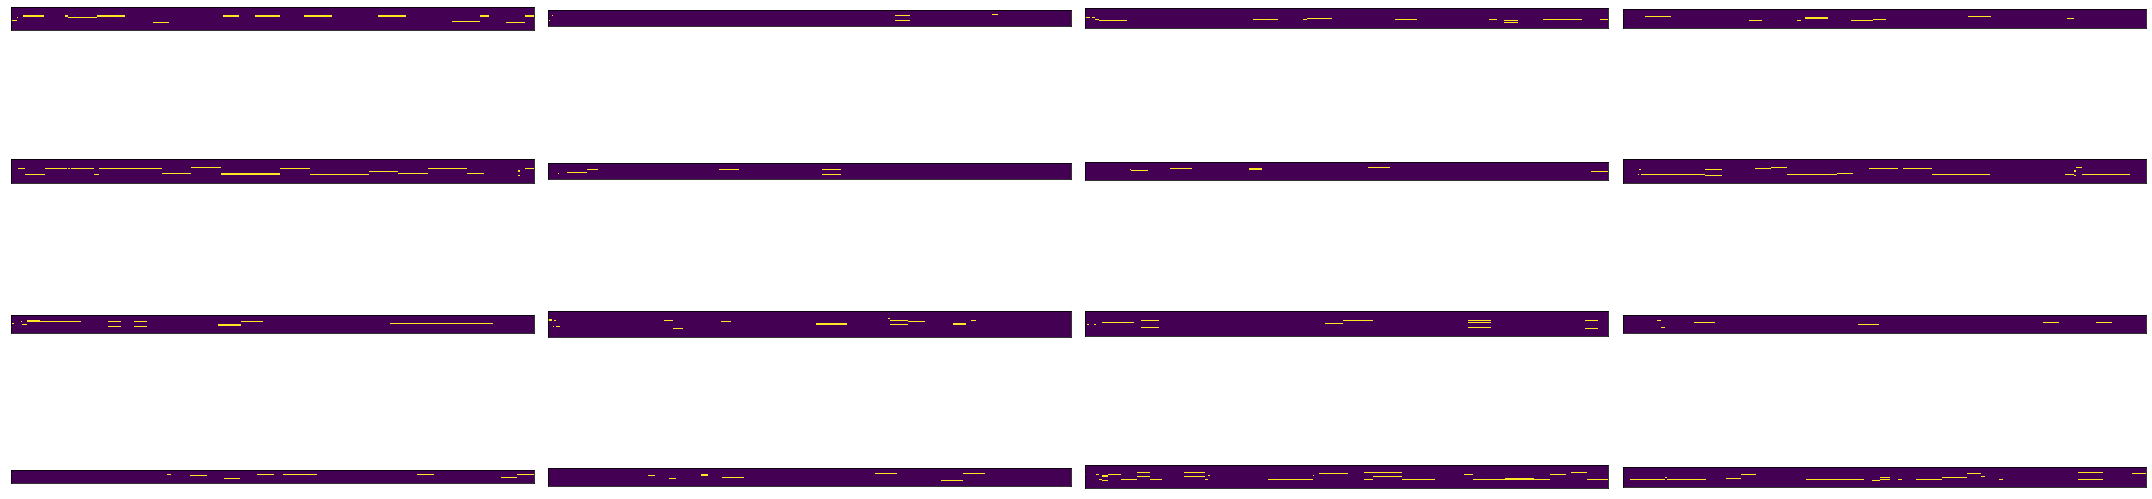

1000/1000 [==============================] - 21s 21ms/step - loss: 13.4360 - duration_output_loss: 0.8166 - notes_output_loss: 12.6194 - duration_output_categorical_accuracy: 0.7119 - notes_output_mean_squared_error: 12.4043 - val_loss: 45.1364 - val_duration_output_loss: 1.1932 - val_notes_output_loss: 43.9432 - val_duration_output_categorical_accuracy: 0.6225 - val_notes_output_mean_squared_error: 43.9243
Epoch 8/100
  94/1000 [=>............................] - ETA: 4s - loss: 45.8008 - duration_output_loss: 1.1718 - notes_output_loss: 44.6290 - duration_output_categorical_accuracy: 0.6249 - notes_output_mean_squared_error: 44.7198Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encounter

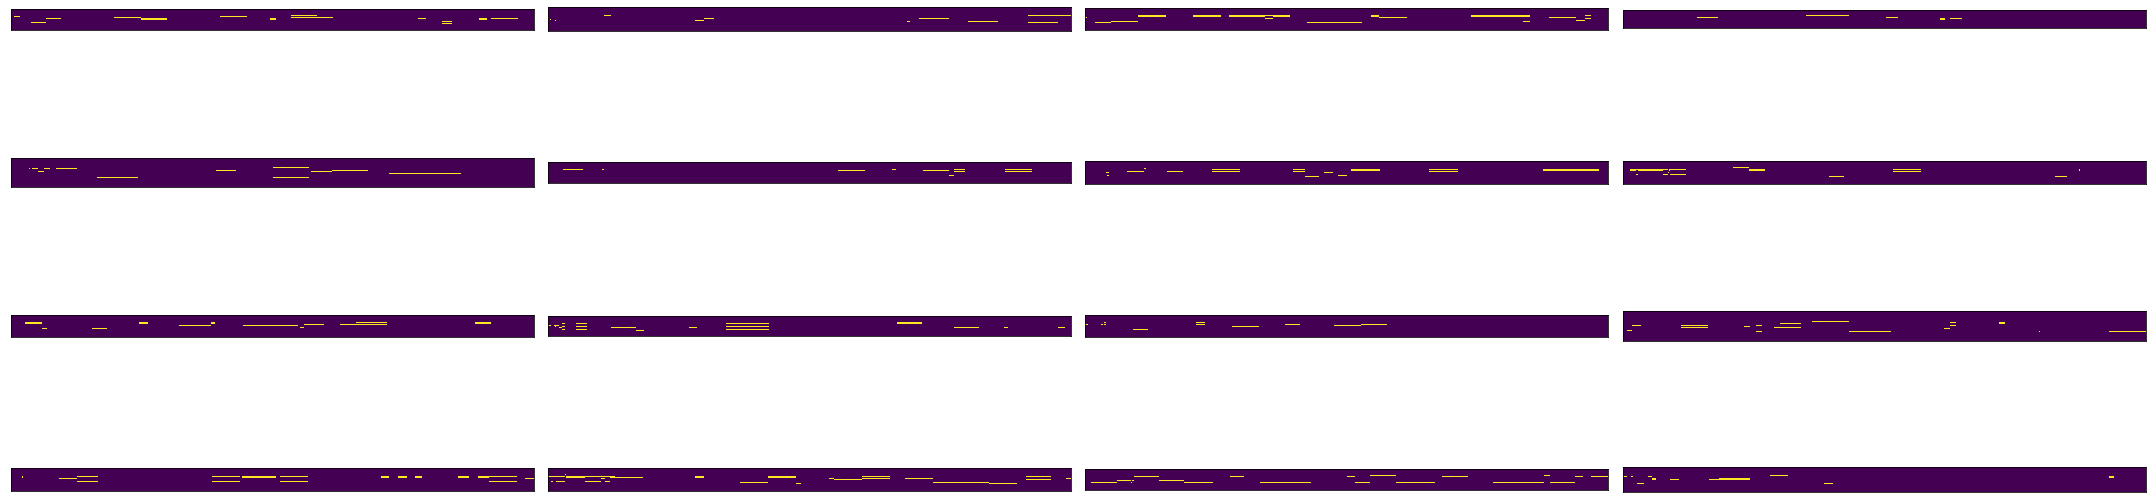

1000/1000 [==============================] - 20s 20ms/step - loss: 12.9528 - duration_output_loss: 0.7972 - notes_output_loss: 12.1556 - duration_output_categorical_accuracy: 0.7140 - notes_output_mean_squared_error: 11.9246 - val_loss: 45.7866 - val_duration_output_loss: 1.1751 - val_notes_output_loss: 44.6115 - val_duration_output_categorical_accuracy: 0.6238 - val_notes_output_mean_squared_error: 44.6955
Epoch 9/100
  93/1000 [=>............................] - ETA: 4s - loss: 46.7707 - duration_output_loss: 1.1770 - notes_output_loss: 45.5937 - duration_output_categorical_accuracy: 0.6295 - notes_output_mean_squared_error: 45.7587Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encounter

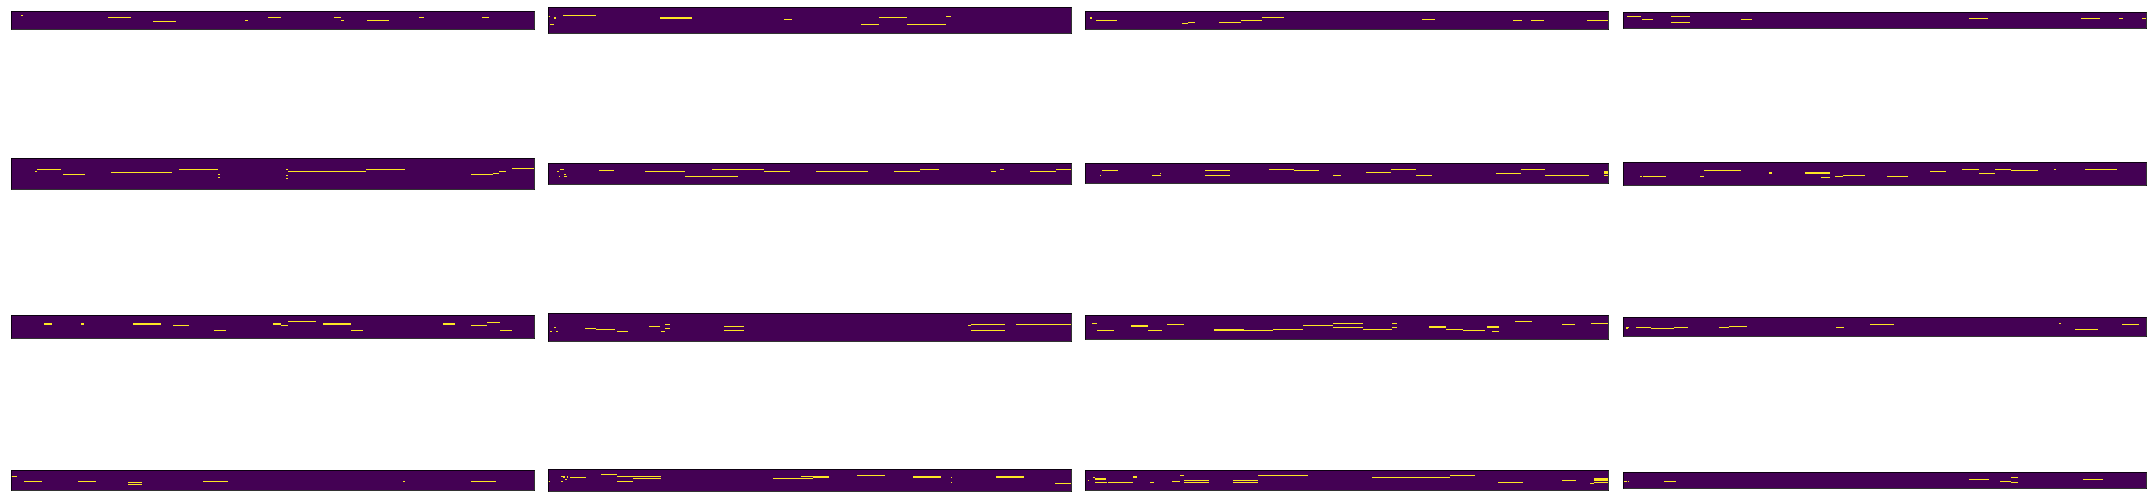

1000/1000 [==============================] - 21s 21ms/step - loss: 12.6233 - duration_output_loss: 0.7875 - notes_output_loss: 11.8358 - duration_output_categorical_accuracy: 0.7151 - notes_output_mean_squared_error: 11.6083 - val_loss: 47.0012 - val_duration_output_loss: 1.1778 - val_notes_output_loss: 45.8233 - val_duration_output_categorical_accuracy: 0.6299 - val_notes_output_mean_squared_error: 46.0089
Epoch 10/100
  98/1000 [=>............................] - ETA: 4s - loss: 46.9447 - duration_output_loss: 1.2056 - notes_output_loss: 45.7391 - duration_output_categorical_accuracy: 0.6051 - notes_output_mean_squared_error: 45.8036Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encounte

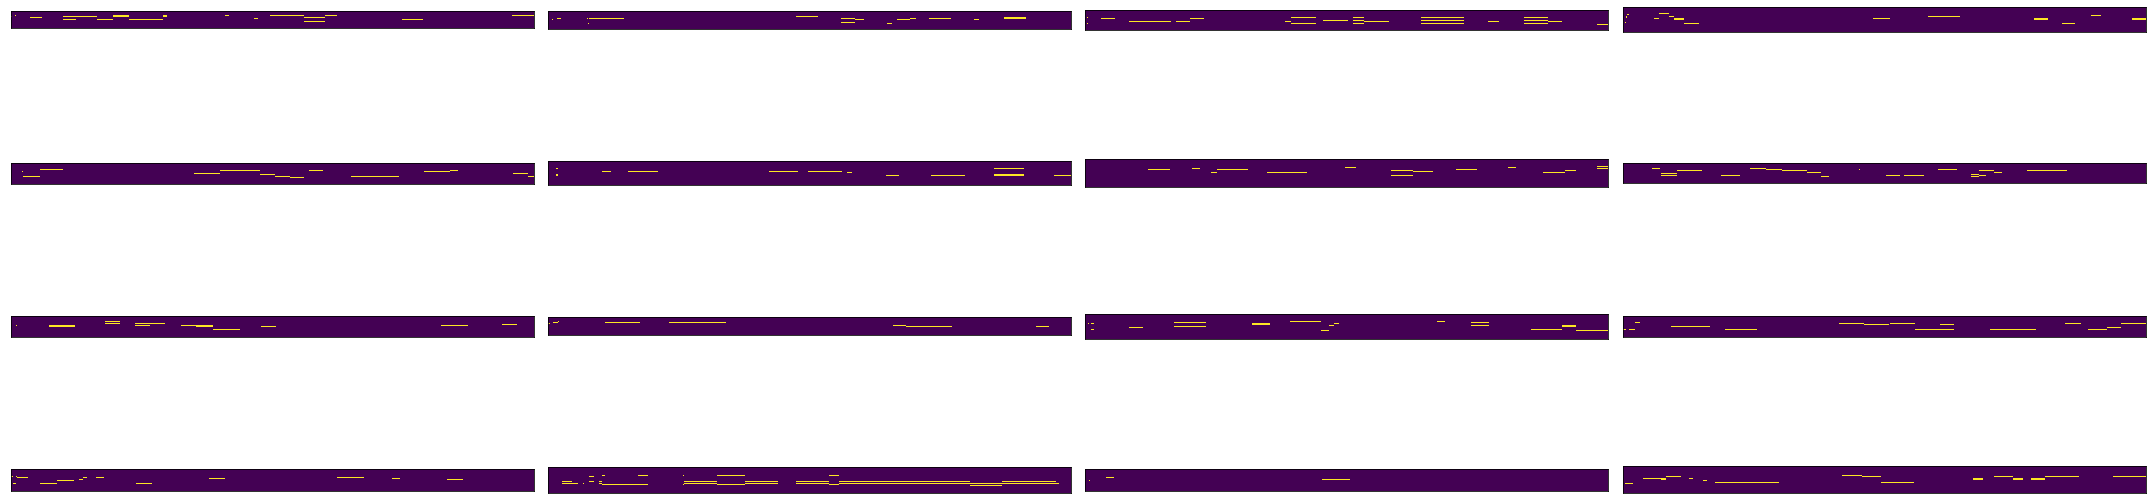

1000/1000 [==============================] - 21s 21ms/step - loss: 12.3420 - duration_output_loss: 0.7752 - notes_output_loss: 11.5667 - duration_output_categorical_accuracy: 0.7187 - notes_output_mean_squared_error: 11.3111 - val_loss: 47.0113 - val_duration_output_loss: 1.2055 - val_notes_output_loss: 45.8058 - val_duration_output_categorical_accuracy: 0.6049 - val_notes_output_mean_squared_error: 45.8957
Epoch 11/100
  91/1000 [=>............................] - ETA: 4s - loss: 46.7418 - duration_output_loss: 1.1943 - notes_output_loss: 45.5474 - duration_output_categorical_accuracy: 0.6213 - notes_output_mean_squared_error: 45.5771Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 1 unknowns per 41 (2%)
Encounte

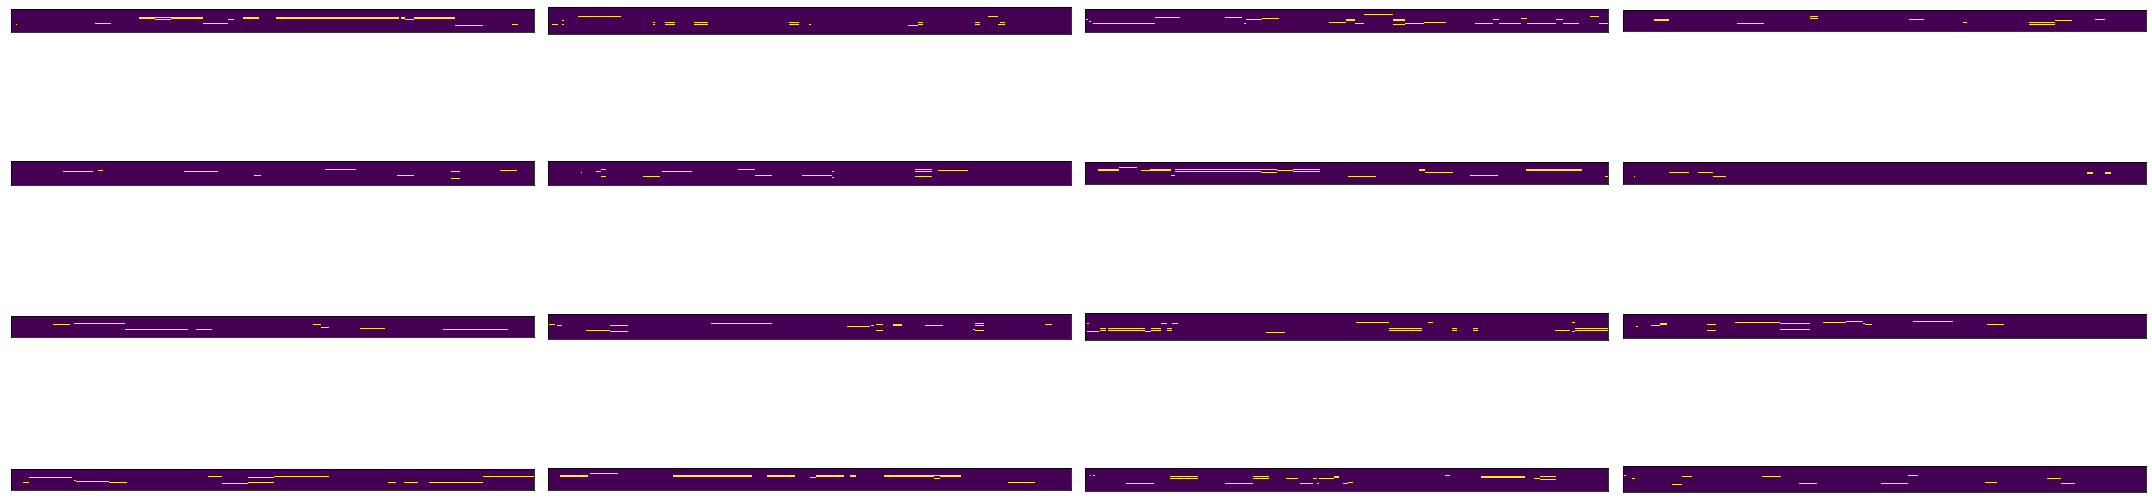

1000/1000 [==============================] - 21s 21ms/step - loss: 11.9823 - duration_output_loss: 0.7700 - notes_output_loss: 11.2123 - duration_output_categorical_accuracy: 0.7205 - notes_output_mean_squared_error: 10.9865 - val_loss: 46.6304 - val_duration_output_loss: 1.1918 - val_notes_output_loss: 45.4386 - val_duration_output_categorical_accuracy: 0.6221 - val_notes_output_mean_squared_error: 45.5671
Epoch 12/100
  91/1000 [=>............................] - ETA: 4s - loss: 48.5733 - duration_output_loss: 1.1781 - notes_output_loss: 47.3952 - duration_output_categorical_accuracy: 0.6153 - notes_output_mean_squared_error: 47.4702Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encounte

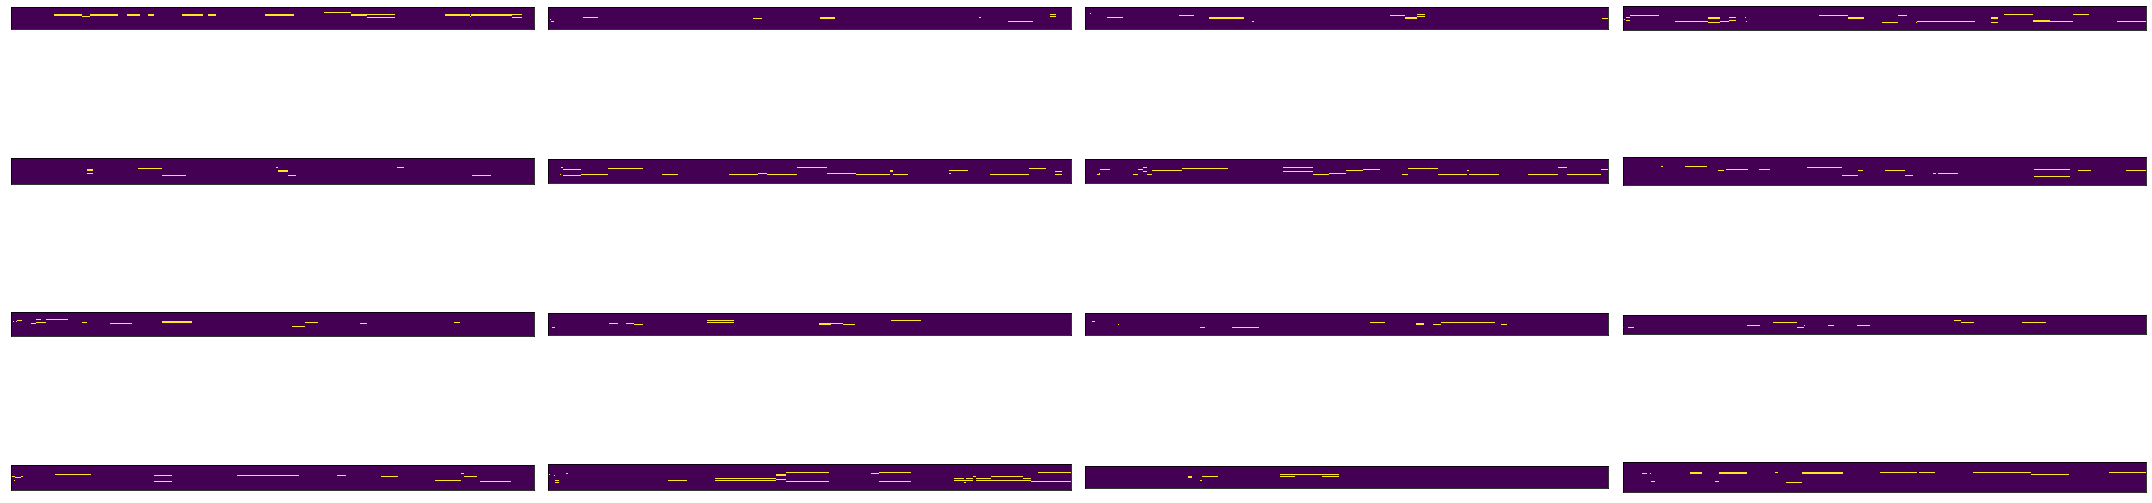

1000/1000 [==============================] - 22s 22ms/step - loss: 11.7707 - duration_output_loss: 0.7513 - notes_output_loss: 11.0194 - duration_output_categorical_accuracy: 0.7252 - notes_output_mean_squared_error: 10.7902 - val_loss: 48.3621 - val_duration_output_loss: 1.1882 - val_notes_output_loss: 47.1740 - val_duration_output_categorical_accuracy: 0.6120 - val_notes_output_mean_squared_error: 47.2201
Epoch 13/100
  88/1000 [=>............................] - ETA: 3s - loss: 48.2716 - duration_output_loss: 1.1781 - notes_output_loss: 47.0935 - duration_output_categorical_accuracy: 0.6179 - notes_output_mean_squared_error: 47.0620Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encounte

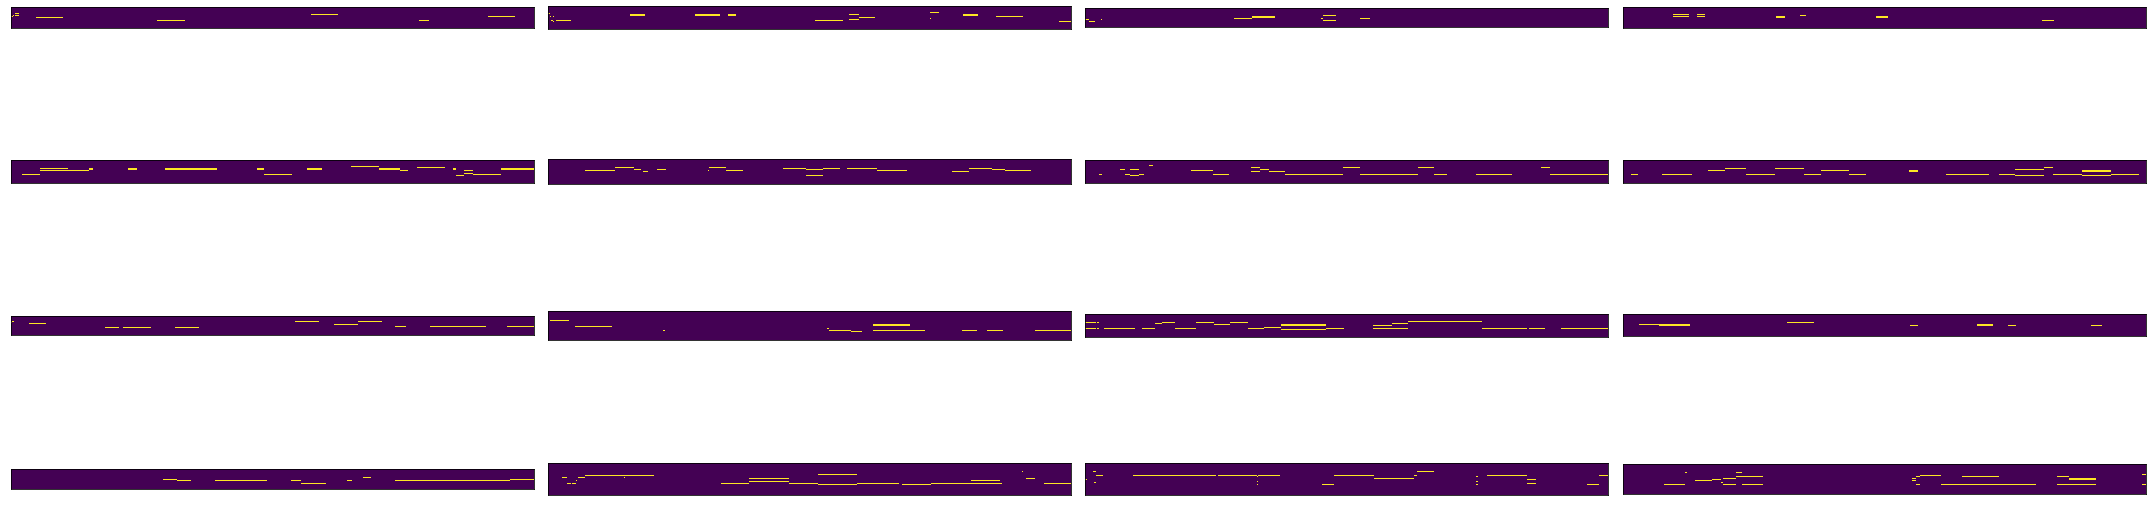

1000/1000 [==============================] - 21s 21ms/step - loss: 11.6505 - duration_output_loss: 0.7494 - notes_output_loss: 10.9011 - duration_output_categorical_accuracy: 0.7255 - notes_output_mean_squared_error: 10.6654 - val_loss: 48.2541 - val_duration_output_loss: 1.1881 - val_notes_output_loss: 47.0661 - val_duration_output_categorical_accuracy: 0.6139 - val_notes_output_mean_squared_error: 47.0430
Epoch 14/100
  95/1000 [=>............................] - ETA: 4s - loss: 46.0053 - duration_output_loss: 1.1754 - notes_output_loss: 44.8299 - duration_output_categorical_accuracy: 0.6258 - notes_output_mean_squared_error: 44.8637Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encountered 0 unknowns per 41 (0%)
Encounte

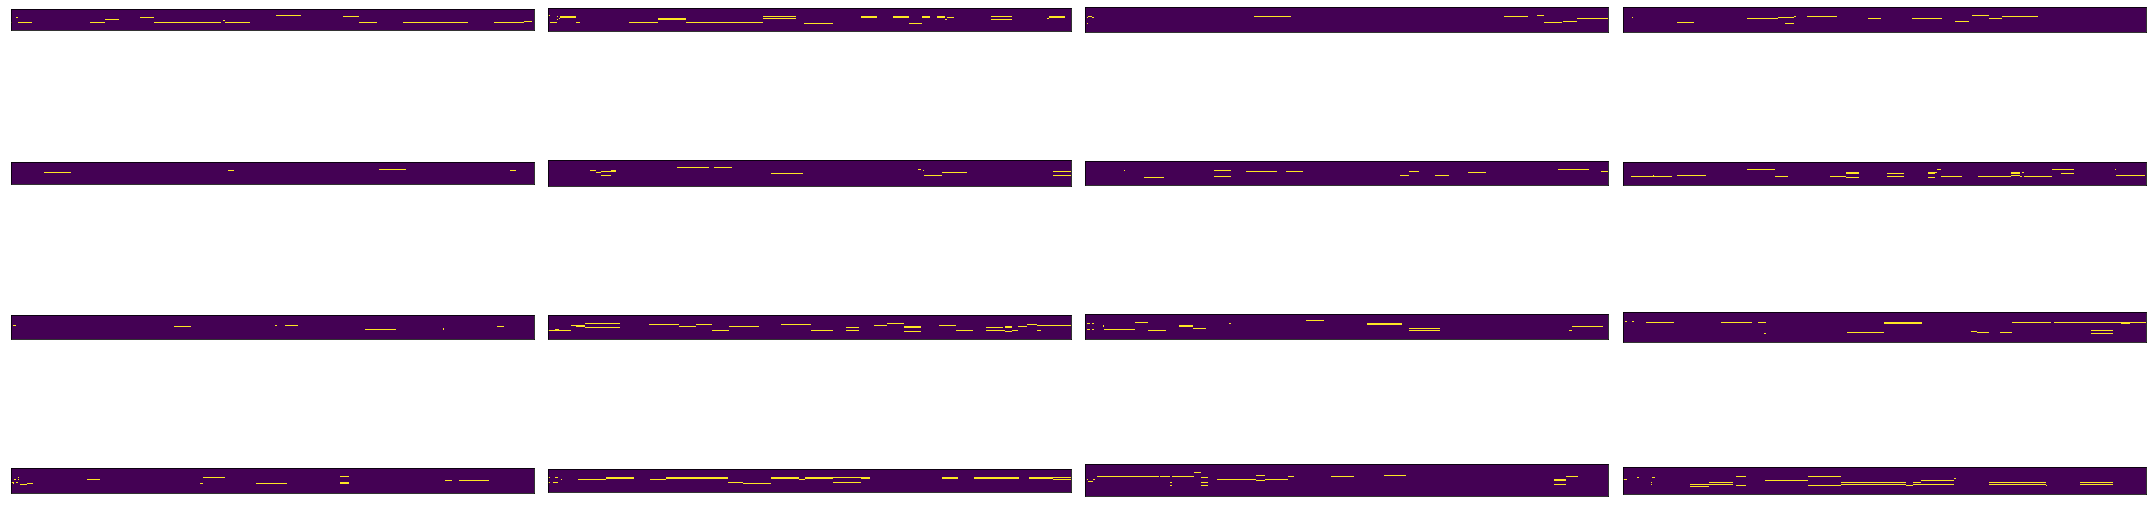

1000/1000 [==============================] - 21s 21ms/step - loss: 11.4679 - duration_output_loss: 0.7428 - notes_output_loss: 10.7251 - duration_output_categorical_accuracy: 0.7259 - notes_output_mean_squared_error: 10.4808 - val_loss: 46.1789 - val_duration_output_loss: 1.1861 - val_notes_output_loss: 44.9928 - val_duration_output_categorical_accuracy: 0.6215 - val_notes_output_mean_squared_error: 45.0586
Epoch 15/100
 596/1000 [================>.............] - ETA: 7s - loss: 11.4192 - duration_output_loss: 0.7334 - notes_output_loss: 10.6857 - duration_output_categorical_accuracy: 0.7297 - notes_output_mean_squared_error: 10.4293

KeyboardInterrupt: 

In [15]:
EPOCHS = 100
STEPS_PER_EPOCH = 1000
TEST_STEPS = 100

start_time = time()
model.fit_generator(
    data_gen,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=test_gen,
    validation_steps=TEST_STEPS,
    callbacks=[gen_callback] #mc, es]
)

minutes_elapsed += (time() - start_time) // 60
epochs_elapsed += EPOCHS

### convert gpu model to cpu

In [ ]:
model_path = 'lstm_clustered_time_embedded/model_best.h5'
model = K.models.load_model(os.path.join(models_base_path, model_path))

In [ ]:
from src.training.common.CUDNNLSTM_LSTM import cudnnlstm_to_lstm

cpu_model = cudnnlstm_to_lstm(model)
cpu_model.compile(
    loss='mean_squared_error',
    optimizer='adam', 
    metrics=["mean_squared_error"],
)

K.models.save_model(cpu_model, os.path.join(models_base_path, model_path).replace('.h5', '_cpu.h5'))